# Claves secretas
## Parámetros para EC-DSA

Definimos p y la curva

In [1]:
p = 2**256 - 2**32 - 2**9 - 2**8 - 2**7 - 2**6 - 2**4 - 1
hex(p)

'0xfffffffffffffffffffffffffffffffffffffffffffffffffffffffefffffc2f'

In [2]:
F = FiniteField(p)
E = EllipticCurve(F,[0, 0, 0, 0, 7])

Calculamos el orden de la curva y comprobamos que verifica el teorema de Hasse

In [3]:
hex(E.order())

'0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141'

In [4]:
abs(E.order() - (p + 1)) < 2 * sqrt(p).round()

True

Efectivamente, verifica el teorema de Hasse, ya que el orden de la curva dista de $p + 1$ menos de $2 \sqrt p$

Ahora comprobaremos que el punto pertenece a la curva al cumplir la ecuación $y^2 = x^3 + 7$

In [5]:
G = E.point([0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798, 0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8])
n = G.order()

In [6]:
(G[1]^2) == (G[0]^3 + 7)

True

Comprobamos que el orden del subgrupo que genera es un número primo

In [7]:
E(G).order()

115792089237316195423570985008687907852837564279074904382605163141518161494337

In [8]:
E(G).order() in Primes()

True

## Elección de claves
Definimos la clave privada y las coordenadas de la clave pública

In [9]:
d = 0x45737461206672617365206D65206C612067756172646F2070617261206DED2E
x = 0x1693AAC9007A1C28B2DF4BEB207ECD6C6A150C324E2066897252756F3BFC375A
y = 0x7F3EF84CC4BBD9C6988E3F77FE38127CF5B8C1513FC399CA26406774722DE01A

In [10]:
Q = d * G
Q

(10211787903232750672517879206297324790815527099291655795773543559125421274970 : 57554989990859528372368617585841543421301199967915050829210147342575953895450 : 1)

Comprobamos que casan

In [11]:
[Q[0], Q[1]] == [x, y]

True

Por si acaso, comprobamos que la clave pública es un punto que pertenece a la curva

In [12]:
Q = E.point([Q[0], Q[1]])
Q[1]^2 == Q[0]^3 + 7

True

La respuesta a la pregunta de si se puede calcular y a partir de x es que sí, ya que para cada x habrá dos posibles valores de y, porque la curva es simétrica con respecto al eje x.
Para saber cuál de los dos valores es el correcto, se guarda en el primer byte de la clave comprimida un 0x02 si y es par y un 0x03 si y es impar, por lo que el prefijo nos indica qué valor escoger.

Por otro lado, no podemos saber x conociendo y debido a que habría 3 posibles soluciones para la ecuación $x = \sqrt[3]{y^2 - 7}$, siendo al menos una solución un número complejo

El fichero contiene _4104 1693 aac9 007a 1c28 b2df 4beb 207e cd6c 6a15 0c32 4e20 6689 7252 756f 3bfc 375a 7f3e f84c c4bb d9c6 988e 3f77 fe38 127c f5b8 c151 3fc3 99ca 2640 6774 722d e01a_,
donde el primer byte sería el _04_, el **prefijo**, que indica que es una clave pública descomprimida (Sabemos que 02 y 03 corresponden a claves comprimidas), los bytes 
_1693 aac9 007a 1c28 b2df 4beb 207e cd6c 6a15 0c32 4e20 6689 7252 756f 3bfc 375a_ corresponden a la **primera coordenada**, y   
_7f3e f84c c4bb d9c6 988e 3f77 fe38 127c f5b8 c151 3fc3 99ca 2640 6774 722d e01a_
corresponden a la **segunda coordenada**.

In [13]:
x = 0xea1901c0f7b9fb4f22f187ced808141ee30714adec3841a7c5209735e0e081e0
x

105885389849248545837190752528902065859154556953915738331353069491375189295584

Sabiendo que la x es 105885389849248545837190752528902065859154556953915738331353069491375189295584 y que el prefijo 03 indica que la y es impar, para hallar la coordenada y debemos resolver la ecuación $y^2 = x^3 + 7$

In [14]:
y2 = (x^3 + 7) % p
y = pow(y2, (p+1)/4, p)
y

7976399251461369506354258185750123002182989095567710819611729233031888812835

En este paso, hemos resuelto la ecuación, lo que nos devuelve un valor de y que, como ahora comprobaremos, está en la curva al verificar la ecuación.
Cabe destacar que para resolver la ecuación, hemos utilizado una propiedad de secp256k1, que es   
$\sqrt y = y^{\dfrac{p+1}{4}}$, y para ello hemos utilizado la función de exponencial modular

In [15]:
y^2 % p == (x^3 + 7) % p

True

Es imposible obtener el valor de d, ya que para obtener la clave pública se usa la operación de multiplicación en una curva elíptica, que es una fórmula matemática que solo se puede calcular en una dirección. Es decir, se puede obtener Q a partir de d, pero no se puede obtener d teniendo Q. Para cualquier clave pública (un punto de la curva), no se puede saber cómo se ha llegado a ese punto, por lo que la única forma de obtener d sería por fuerza bruta, pero los 256 bits de la clave privada y sus $2^{256}$ posibles combinaciones lo hacen inviable.  
<img src="https://cryptochamp.com/wp-content/uploads/2018/07/Figure-2-Elliptic-Curve-with-multiplication-300x300.png"
     style="display: block;
            margin-left: auto;
            margin-right: auto;"/>

## Presencia de las claves en los bloques Bitcoin

Para convertir los ficheros descargados a ficheros binarios, bastaría con ejecutar el comando **xxd -r -p fichero_descargado > fichero_binario**

Por último, al ejecutar **01_extrae_scriptsPubs** con el fichero 000009.raw y después **01_extrae_pub** con el fichero resultante del comando anterior, tenemos la siguiente clave pública:

In [16]:
x = 0x11DB93E1DCDB8A016B49840F8C53BC1EB68A382E97B1482ECAD7B148A6909A5C
y = 0xB2E0EADDFB84CCF9744464F82E160BFA9B8B64F9D4C03F999B8643F656B412A3

In [17]:
y^2 % p == (x^3 + 7) % p

True

Y como podemos observar, es un punto que pertenece a la curva porque cumple la ecuación $x = \sqrt[3]{y^2 + 7}$

# Pasar a la firma

**Comprueba, utilizando Sage, que ambas firmas (la recién obtenida con el programa y la calculada conSage) son válidas para mensaje_01.txt.**


In [18]:
d = 0x45737461206672617365206D65206C612067756172646F2070617261206DED2E
m = 0x546F646F20617175656C6C6F20636F727265206465206D69206375656E74612E
k = randint(2 ** 255, 2 ** 255 + 2 ** 254)
xR = (k * G)[0]
r = ZZ(xR) % n; r == 0

False

In [19]:
F2 = FiniteField(n)
s = ZZ(F2(k) ** (-1)) * (m + d * r) % n; s == 0

False

(r, s)

In [20]:
s_1 = int(1 / F2(s))

En primer lugar, definimos s_1 como la inversa de s tal que $s \cdot s^{-1} \equiv 1 \; mód  \; n$  
Ahora, comprobaremos que $(m \cdot s^{-1}) G + (r \cdot s^{-1}) Q = r \; mód \; n$

In [21]:
(m * s_1 * G + r * s_1 * Q)[0] == r % n

True

Comprobamos ahora que la firma generada por el programa es válida

In [22]:
r = 0x6475F0FBB3D460C733A21C5E3FA739F2ADE004A81C39FC81250B90E0448DCD50
s = 0x53394E619FF16DABFE71AB1BB5B020E99E365AD58CA770072B5F5B8763AC26DA

In [23]:
s_1 = int(1 / F2(s))
(m * s_1 * G + r * s_1 * Q)[0] == r % n

True

**Realiza la verificación reemplazando s por n − s. Demuestra que, si (r, s) es una firma válida, también lo es (r, n − s).**

Sabemos que $n \; mód \; n = 0$, por lo que comprobaremos si la firma con (r, -s) es válida

In [24]:
s = -s
s_1 = int(1 / F2(s))
(m * s_1 * G + r * s_1 * Q)[0] == r % n

True

Efectivamente, la firma con (r, -s) es válida porque, como hemos comentado anteriormente, la curva tiene simetría con respecto al eje x, por lo que el valor de $X_R$ será el mismo para $s$ y para $-s$

**Con la clave privada correspondiente, hemos firmado mensaje_01.txt. ¿Se corresponde alguna de las
firmas siguientes con esa clave y este mensaje?**

Ejecutando el programa 02_comprueba, podemos afirmar que firma_03 y firma_05 corresponden al mensaje_01, pero no la segunda firma.  
Para comprobarlo ahora con sage, definiremos una función para comprobar si una firma corresponde a un mensaje con una clave dada.

In [25]:
def compruebaFirma(msg, clave, firma):
    r = firma[0]
    s = firma[1]
    s_1 = int(1 / F2(s))
    return (msg * s_1 * G + r * s_1 * clave)[0] == r % n

Primero definimos la clave pública

In [26]:
Q = E(0xEA1901C0F7B9FB4F22F187CED808141EE30714ADEC3841A7C5209735E0E081E0, 0x11a27b63a37aabb54a4e226a075a4095ce4678ca33da0ed8665b30460bc2bb23)

Firma_03

In [27]:
firma = (0xD3FE590319899F970F2A5074CC931BE02EF5F1C702433FD611529389B4A20BA5, 0x3315A17CFC631D3B9D2E22E739E795B2AC849C2638916071B2DB0EBCCA180C71)
compruebaFirma(m, Q, firma)

True

Firma_04

In [28]:
firma = (0x27871E5EDFF45363961D5FA96E9C8219FFAEDCF50BD06B663A4DC97B04506324, 0x6EB2BAC70ED0F499FF78CA59721EC469AA89C106B4540731ACAEBB6ABD370361)
compruebaFirma(m, Q, firma)

False

Firma_05

In [29]:
firma =  0x3B99865AD8A13A74E08512553E7423DB164151905EB5C657A567F02A89277DE8, 0x68E83F426286CC2C266EA6431262E21F65B010430E0962DF40B0461493822507
compruebaFirma(m, Q, firma)

True

**En realidad, las tres son firmas reales para la clave publica_02.raw. Lo que ocurre es que no todas firman
el mensaje mensaje_01.txt. ¿Sabrías recuperar ese o esos otros mensajes?**

No podemos recuperar el mensaje, ya que, como hemos explicado anteriormente, la multiplicación en una curva elíptica es una operación matemática de una sola dirección.

### Firma de transacciones

**Para su firma, el hash resaltado en gris ha de interpretarse como un número escrito con la codificación big-endian (h = 0x169E...). ¿Constituye una firma válida para ese mensaje con respecto a la clave pública
marcada en verde el par destacado en amarillo?**

De nuevo, primero definimos la clave pública, y después comprobaremos si el mensaje (El hash, en este caso) y la firma se corresponden con dicha clave pública

In [30]:
Q = E(0x11db93e1dcdb8a016b49840f8c53bc1eb68a382e97b1482ecad7b148a6909a5c, 0xb2e0eaddfb84ccf9744464f82e160bfa9b8b64f9d4c03f999b8643f656b412a3)

In [31]:
msg_hash = 0x169E1E83E930853391BC6F35F605C6754CFEAD57CF8387639D3B4096C54F18F4
firma = 0x4E45E16932B8AF514961A1D3A1A25FDF3F4F7732E9D624C6C61548AB5FB8CD41, 0x181522EC8ECA07DE4860A4ACDD12909D831CC56CBBAC4622082221A8768D1D09
compruebaFirma(msg_hash, Q, firma)

False

En este caso, parece que la firma no es válida para el mensaje y la clave

**El ejecutable 02_prepara_tr devuelve el hash de la transacción modificada. Comprueba que (esta vez sí)
la firma incluida en la segunda transacción del bloque #170 es válida.**

In [32]:
msg_hash = 0x7A05C6145F10101E9D6325494245ADF1297D80F8F38D4D576D57CDBA220BCB19
compruebaFirma(msg_hash, Q, firma)

True

Ahora la firma sí se corresponde con el hash generado por el ejecutable *02_prepara_tr*

**Comprueba la firma de la segunda transacción del bloque #181.**

Antes de nada, ejecutaremos los siguientes comandos:
* 02_extrae_tr ../bloques/000181.raw 1 tr000181.raw *para extraer la transacción*
* 02_extrae_scriptPub tr000181.raw 1 sc000181.raw *para extraer el script que contiene la clave pública*
* 02_prepara_tr tr000181.raw sc000181.raw 0 hash000181.raw *para extraer el hash*  

Tras ejecutar estos comandos, ya tenemos el hash


In [33]:
msg_hash = 0x7EC2D4AF029C4945EB6CB4B556153382681075B5E64315A47D0A6CD1AADA3321

Ahora, ejecutaremos los dos siguientes comandos para obtener la firma:
* 02_extrae_scriptSig tr000181.raw 0 scsig000181.raw
* 02_extrae_firma scsig000181.raw firma000181.raw 

In [34]:
firma =  0x27542A94D6646C51240F23A76D33088D3DD8815B25E9EA18CAC67D1171A3212E, 0x3BAF203C6E7B80EBD3E588628466EA28BE572FE1AAA3F30947DA4763DD3B3D2B
compruebaFirma(msg_hash, Q, firma)

True

Efectivamente, la firma se corresponde con el mensaje y la clave pública

**Comprueba la firma de la séptima transacción del bloque #92240.**

Ejecutaremos la misma sucesión de comandos que en el apartado anterior para extraer la firma y el hash, con la diferencia de que en el primer comando deberemos poner un 7 en vez de un 1 para extraer la séptima transacción y no la primera.  
También ejecutaremos **01_extrae_pub** para extraer la clave pública
El resultado de ejecutar los comandos será el siguiente:

In [35]:
msg_hash = 0xA9C4941033AA0DF1A75705D982B35C3CB089DE3085EF1C7997E0BE7576607C63
firma = 0x576497B7E6F9B553C0ABA0D8929432550E092DB9C130AAE37B84B545E7F4A36C,  0x66CB982ED80608372C139D7BB9AF335423D5280350FE3E06BD510E695480914F

# Nueva clave publica
Q_new = E(0xAE1A62FE09C5F51B13905F07F06B99A2F7159B2225F374CD378D71302FA28414, 0xE7AAB37397F554A7DF5F142C21C1B7303B8A0626F1BADED5C72A704F7E6CD84C)

compruebaFirma(msg_hash, Q_new, firma)

True

# Blockchain

### Incentivos

**¿Cuántos bitcoins se generan en las coinbase transactions de los bloques que se están incorporando hoy a la cadena?**

Pues explorando alguno de los bloques más recientes a dia de hoy (05/01/2022), concretamente el bloque #717330 vemos que se generan 6.25 BTCs como "recompensa del bloque".

**¿Qué altura tendrá el último bloque que premie al minero con este incentivo? ¿A cuánto ascenderá entonces el monto total de bitcoins en el sistema?**

Para calcular esto, hemos de conocer tras cuántas divisiones entre 2, la recompensa con la que se premia en una conbase transaction (que inicialmente está situada en 50 bitcoin, $50 * 10^{8}$ *satoshis*) será menos que 1 satoshi. Luego sólo tendremos que multiplicar este número por el número de transacciones que han de realizarsae para que se produzca una división entre 2 (210000) y restarle 1 para obtener la altura del último bloque premiado. Dicho número de divisiones vendrá dado por: $$\lfloor \log_2(50*10^{8}) \rfloor + 1 = 33$$
De este modo, la altura de ese último bloque recompensado será: $$(33*210000) - 1 = 6929999$$

Para calcular el total de bitcoins que habrá en circulación por el sistema tendremos que calcular la suma de las recompensas de cada "tramo" antes de que esta sea 0. El siguiente algoritmo nos realizará dicha suma.

In [36]:
coinbase = 50 
n_blocks = 210000
total = float(0)

while coinbase * (10 ** 8) > 1:
    total += n_blocks * coinbase
    coinbase /= 2
    
print(total)

20999999.99755528


**Suponiendo un ritmo constante de adición de bloques de uno cada diez minutos, ¿cuándo se prevé alcanzar ese máximo nivel de circulante?**

El numero de años que se tardará en alcanzarlo vendrá dado por:

In [37]:
time_mins = 10 * 210000 * 33
time_years = float((((time_mins / 60) / 24) / 30) / 12)
print(time_years)

133.68055555555554


Esto nos lleva a concluir que para alcanzar dicha fecha han de pasar (de acuerdo con el enunciado) casi 134 años. Esto estaría entorno al año 2143 (2009 fecha del genesis block + 134).

### Dificultad

**¿Cuántas variantes del bloque cabe esperar que haya que probar hasta dar con una cabecera cuyo hash no exceda esta cota?**

Hemos de probar entonces todas las anteriores combinaciones de bits marcadas por la codificación de este último byte del campo *nBits*, que en este caso vale 0x17, es decir, 23 bytes de combinaciones. Por tanto, hemos de probar $2 ^ {8*(23 - 3)} = 2 ^ {160} = 1461501637330902918203684832716283019655932542976$ variantes del bloque.

**En aquellos días de 2009, ¿cuántos intentos habría que haber hecho para anotarse 50 BTC?**

Podemos definir la probabilidad de acierto por cada variante de bloque como $p_{bloque} = \frac{\mbox{valor de la cota}}{\mbox{nº total de combinaciones}}$. De este modo, tendremos que hacer $p_{bloque}^{-1}$ intentos (en promedio y de acuerdo a una distribución uniforme de probabilidad) para acertar. Por tanto, para este valor de 0xFFFF00 (= 65535 en *little endian*) de los tres primeros bytes y de para el último byte de 0x1D = 29 tendremos que: $$p_{bloque}^{-1} = \frac{\mbox{nº total de combinaciones}}{\mbox{valor de la cota}} = \frac{2^{256}}{int(\mbox{0x00FFFF})*2^{(29-3) * 8} + 1} = \frac{2^{256}}{65535 *2^{(29-3) * 8} + 1} = 4295032833$$ Por lo que habría que hacer mas de 4 billones de intento en promedio. Hemos de mencionar también que le sumamos 1 al valor de la cota ya que la cota nos direcciona valores desde 0 hasta $n$, por lo que el valor real será $n + 1$.

**Extrae tres bloques de la cadena, con alturas $h_{0}$, $h_{1}$ y $h_{2}$, bien separadas entre sí, y calcula el tiempo medio transcurrido entre bloques para el intervalo desde $h_{0}$ hasta $h_{1}$, por una parte, y desde $h_{1}$ hasta $h_{2}$, por otra: $$\frac{t_{1} - t_{0}}{h_{1} - h_{0}} \mbox{ y } \frac{t_{2} - t_{1}}{h_{2} - h_{1}}.$$ ¿Se aprecia un cambio en el ritmo de la minería?**

Tomaremos los bloques con alturas $h_{0} = 0, h_{1} = 358715\mbox{ y } h_{2} = 717430$ que tienen valores $t_{0} = 1231006505, t_{1} = 1433022668\mbox{ y } t_{2} = 1641467042$. Estas tres alturas se corresponden con, el último bloque en este preciso instante (06/01/2022), el primer bloque  (03/01/2009) y el bloque que de acuerdo con su altura se sitúa numéricamente en medio de ambos (30/05/2015).

Para obtener los dato de tiempo en formato UNIX, hemos utilizado el comando `$ wget https://blockchain.info/block-height/` añadiendo al final el valor de la altura del bloque cuyo a tributo de tiempo queremos obtener, y nos hemos quedado con el valor del campo "`time`"

Dicho esto, los valores de $v_{0-1}$ y $v_{1-2}$ serán:

In [38]:
# Tuplas de pares tiempo UNIX - altura
b0 = (1231006505, 0)
b1 = (1433022668, 358715)
b2 = (1641467042, 717430)

v_01 = float((b1[0] - b0[0]) / (b1[1] - b0[1]))
v_12 = float((b2[0] - b1[0]) / (b2[1] - b1[1]))
print("v0-1 = " + str(v_01), "v1-2 = " + str(v_12))

v0-1 = 563.1661987929136 v1-2 = 581.0863052841393


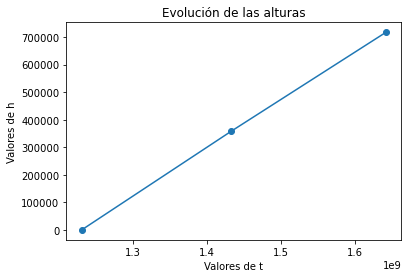

In [39]:
import matplotlib.pyplot as plt

bloques = [b0, b1, b2]
tiempos = [b[0] for b in bloques]
alturas = [b[1] for b in bloques]

plt.title("Evolución de las alturas")
plt.plot(tiempos, alturas)
plt.scatter(tiempos, alturas)
plt.xlabel('Valores de t')
plt.ylabel('Valores de h')
plt.show()

No podemos concluir que haya habido un cambio en el ritmo de minería, al menos con tan pocos puntos de muestra. La oscilación de los valores calculados de $v_{0-1}$ y $v_{1-2}$ es mínima, y esto se aprecia en la gráfica generada. Pues estos valores se corresponderán con las pendientes de cada tramo de la recta.

**¿De cuantas maneras distintas se puede rellenar el campo nNonce?**

El campo nNonce es un numero aleatorio a eleccion del minero el cual ocupa 4 bytes en el bloque, por lo que el numero de combinaciones posibles para este será:

In [2]:
nNonce = pow(2, 8 * 4)
nNonce

4294967296

**La minería de bloques consiste en ajustar algunos bytes para construir un bloque cuyo hash tenga la forma
requerida. De manera análoga, un impostor podría intentar cambiar la coinbase transaction de un bloque
«enterrado» en la cadena, colocando como output una dirección controlada por él. El contenido arbitrario
del campo scriptSig puede modificarse tanto como sea necesario para que el hash hashMerkleRoot
coincida con el del bloque original. ¿Qué impide esta trampa?**

Al tener en la cabecera del bloque el hash de la lista de todas las transacciones previas, se garantiza la integridad de la cadena de bloques, pues al hacer cambios en una transaccion , se modificaria el hash del conjunto, lo que a su vez modificaria el hash de la cabecera del bloque, lo que obligaria a la modificacion de todos los bloques anteriores, por lo que es computacionalmente imposible realizar esta "trampa".